In [22]:
from time import time
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from matplotlib.ticker import FuncFormatter
from xgboost import XGBRegressor  

In [23]:
df = pd.read_csv('../data/processed/stocks.csv')

In [24]:
df

,date,close,volume,open,high,low,ticker,returns,rsi,kama,ema,tema,mfi,obv
0,2015-12-23,27.1525,130472560,26.8175,27.2125,26.8000,AAPL,-0.005340,41.899128,27.541394,27.504445,26.761478,18.818790,-573985480.0
1,2015-12-24,27.0075,54386720,27.2500,27.2500,26.9875,AAPL,-0.011201,40.616972,27.461440,27.414092,26.774391,15.911017,-628372200.0
2,2015-12-28,26.7050,106559720,26.8975,26.9225,26.5452,AAPL,0.017974,38.004155,27.368836,27.285166,26.664920,16.684601,-734931920.0
3,2015-12-29,27.1850,123649040,26.7400,27.3575,26.7150,AAPL,-0.013059,44.144184,27.360072,27.266954,26.825755,25.161975,-611282880.0
4,2015-12-30,26.8300,100736360,27.1450,27.1750,26.7950,AAPL,-0.019195,40.916589,27.338830,27.187508,26.786950,26.994879,-712019240.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99435,2025-11-05,113.6800,12400920,114.0900,115.1800,113.6700,XOM,0.007213,49.590064,114.245022,114.280156,114.103307,38.528294,-116805389.0
99436,2025-11-06,114.5000,14219650,113.6400,114.9350,113.6400,XOM,0.023755,52.849917,114.253144,114.320128,114.215942,38.072675,-102585739.0
99437,2025-11-07,117.2200,17181150,115.2100,117.5050,114.9000,XOM,0.008531,61.697898,114.344278,114.847377,115.526101,48.320808,-85404589.0
99438,2025-11-10,118.2200,13047960,117.4400,118.4500,115.4550,XOM,0.013196,64.346858,114.493968,115.460581,116.847265,56.771834,-72356629.0


In [25]:
df.columns

Index(['date', 'close', 'volume', 'open', 'high', 'low', 'ticker', 'returns',
       'rsi', 'kama', 'ema', 'tema', 'mfi', 'obv'],
      dtype='object')

In [26]:
columns_to_drop = [c for c in df.columns if 'lag' in c] + ['open', 'close', 'high', 'low', 'dollar_vol', 'dollar_vol_rank', 'volume'] + [c for c in df.columns if 'year' in c] + [c for c in df.columns if 'month' in c]
print(f"Columns to drop: {columns_to_drop}")
print(f"Available columns: {list(df.columns)}")

# Only drop columns that actually exist
existing_lag_columns = [c for c in columns_to_drop if c in df.columns]
if existing_lag_columns:
    df = df.drop(existing_lag_columns, axis=1)
    print(f"Dropped {len(existing_lag_columns)} columns")
else:
    print("No lag columns found to drop")

Columns to drop: ['open', 'close', 'high', 'low', 'dollar_vol', 'dollar_vol_rank', 'volume']
Available columns: ['date', 'close', 'volume', 'open', 'high', 'low', 'ticker', 'returns', 'rsi', 'kama', 'ema', 'tema', 'mfi', 'obv']
Dropped 5 columns


In [27]:
df.columns

Index(['date', 'ticker', 'returns', 'rsi', 'kama', 'ema', 'tema', 'mfi',
       'obv'],
      dtype='object')

In [28]:
df.set_index(['ticker', 'date'], inplace=True)

### Split data

In [29]:
dates_available = df.index.get_level_values('date').unique()
dates_available

Index(['2015-12-23', '2015-12-24', '2015-12-28', '2015-12-29', '2015-12-30',
       '2015-12-31', '2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
       ...
       '2025-10-29', '2025-10-30', '2025-10-31', '2025-11-03', '2025-11-04',
       '2025-11-05', '2025-11-06', '2025-11-07', '2025-11-10', '2025-11-11'],
      dtype='object', name='date', length=2486)

In [30]:
split_index_id = int(np.floor(len(dates_available) * 0.8))
split_index_id

1988

split_index_id = int(np.floor(len(dates_available) * 0.8))
split_index_id

In [31]:
split_date = dates_available[split_index_id]
split_date

'2023-11-16'

In [32]:
train_df = df[df.index.get_level_values('date') < split_date]
test_df = df[df.index.get_level_values('date') >= split_date]

In [33]:
print(train_df.shape)
print(test_df.shape)

(79520, 7)
(19920, 7)


In [34]:
y_train = train_df.filter(like='returns')
y_test = test_df.filter(like='returns')
X_train = train_df.drop(y_train.columns, axis=1)
X_test = test_df.drop(y_test.columns, axis=1)

In [35]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(79520, 6)
(19920, 6)
(79520, 1)
(19920, 1)


In [36]:
class CV:
    """Generate tuples of train-idx, test_idx pairs"""
    def __init__(self,
            n_splits=3,
            train_period_length=63,
            test_period_length=10,
            lookahead=None):
        self.n_splits = n_splits
        self.train_length = train_period_length
        self.test_length = test_period_length
        self.lookahead = lookahead

    def split(self, X, y=None, groups=None):   # <-- added groups
        unique_dates = X.index.get_level_values('date').unique()
        dates_df = X.reset_index()[['date']]
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        for train_start, train_end, test_start, test_end in split_idx:
            if train_start >= len(days) or test_end < 0:
                continue
            train_idx = dates_df[(dates_df.date > days[train_start])
                                 & (dates_df.date <= days[train_end])].index
            test_idx = dates_df[(dates_df.date > days[test_start])
                                & (dates_df.date <= days[test_end])].index
            if len(train_idx) > 0 and len(test_idx) > 0:
                yield train_idx, test_idx

In [37]:
train_period_length = 63
test_period_length = 10
n_splits = int(len(X_train.index.get_level_values('date').unique()) / test_period_length) 
lookahead = 1

cv = CV(n_splits=n_splits,
        train_period_length=train_period_length,  
        test_period_length=test_period_length,    
        lookahead=lookahead)

In [38]:
i = 0
for train_idx, test_idx in cv.split(X=X_train):
    train = X_train.iloc[train_idx]
    test = X_train.iloc[test_idx]
    
    # Get actual date values
    train_dates = train.reset_index()['date']
    test_dates = test.reset_index()['date']
    
    # Count stocks per period and show date ranges
    train_stock_count = len(train['ticker'].unique()) if 'ticker' in train.columns else len(train)
    test_stock_count = len(test['ticker'].unique()) if 'ticker' in test.columns else len(test)
    
    print(f"Split {i+1}: 63 {train_dates.min()} to {train_dates.max()}, "
          f"10 {test_dates.min()} to {test_dates.max()}")
    
    i += 1
    if i == 10:
        break

Split 1: 63 2023-08-04 to 2023-11-01, 10 2023-11-02 to 2023-11-15
Split 2: 63 2023-07-21 to 2023-10-18, 10 2023-10-19 to 2023-11-01
Split 3: 63 2023-07-07 to 2023-10-04, 10 2023-10-05 to 2023-10-18
Split 4: 63 2023-06-22 to 2023-09-20, 10 2023-09-21 to 2023-10-04
Split 5: 63 2023-06-07 to 2023-09-06, 10 2023-09-07 to 2023-09-20
Split 6: 63 2023-05-23 to 2023-08-22, 10 2023-08-23 to 2023-09-06
Split 7: 63 2023-05-09 to 2023-08-08, 10 2023-08-09 to 2023-08-22
Split 8: 63 2023-04-25 to 2023-07-25, 10 2023-07-26 to 2023-08-08
Split 9: 63 2023-04-11 to 2023-07-11, 10 2023-07-12 to 2023-07-25
Split 10: 63 2023-03-27 to 2023-06-26, 10 2023-06-27 to 2023-07-11


In [39]:
# target = f'target_{lookahead}d'
target = 'returns'
target

'returns'

In [41]:
outcome_data = (X_train
                .join(y_train[[target]])
                .dropna())
print(f"Training rows (with target): {outcome_data.shape[0]} | Features: {X_train.shape[1]}")

def spearman_ic(y_true, y_pred):
    return spearmanr(y_true, y_pred)[0]

spearman_scorer = make_scorer(spearman_ic, greater_is_better=True)

xgb_grid = {
    "learning_rate":     [0.03, 0.1],
    "max_depth":         [4, 6],
    "min_child_weight":  [3],
    "subsample":         [0.7],
    "colsample_bytree":  [0.7],
}

# 'max_depth': 4, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'learning_rate': 0.1

X_for_cv = outcome_data.drop(columns=[target])
precomputed_splits = list(cv.split(X_for_cv))  # reuse existing custom CV indices

xgb_base = XGBRegressor(
    objective='reg:squarederror',
    booster='gbtree',
    n_jobs=-1,
    random_state=42,
    verbosity=0
)

gcv = GridSearchCV(
    estimator=xgb_base,
    param_grid=xgb_grid,
    scoring=spearman_scorer,
    cv=precomputed_splits,
    n_jobs=-1,
    refit=False,
    verbose=1
)
gcv.fit(X_for_cv, outcome_data[target])

cv_results_df = (pd.DataFrame(gcv.cv_results_)
                 .sort_values("rank_test_score")
                 .reset_index(drop=True))
display(cv_results_df.head(10))
print("Best (overall IC scorer) params:", cv_results_df.iloc[0].params)

Training rows (with target): 79520 | Features: 6
Fitting 192 folds for each of 4 candidates, totalling 768 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_subsample,params,...,split185_test_score,split186_test_score,split187_test_score,split188_test_score,split189_test_score,split190_test_score,split191_test_score,mean_test_score,std_test_score,rank_test_score
0,0.144798,0.044953,0.007054,0.001933,0.7,0.03,6,3,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",...,0.081661,0.104854,-0.080361,0.057287,-0.025461,-0.030134,0.024218,0.037167,0.063706,1
1,0.150056,0.050868,0.007030,0.001986,0.7,0.10,6,3,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",...,0.058661,0.146330,-0.058309,0.048197,0.046036,0.014354,-0.006596,0.034844,0.063393,2
2,0.080274,0.025906,0.005563,0.001492,0.7,0.03,4,3,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",...,0.110118,0.150858,-0.063115,0.068492,0.008954,-0.024683,0.020066,0.034829,0.065244,3
3,0.082785,0.025653,0.005668,0.001754,0.7,0.10,4,3,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",...,0.074939,0.156792,-0.058110,0.060817,-0.017088,-0.029616,0.008750,0.030581,0.061506,4


Best (overall IC scorer) params: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.7}


In [42]:
best_params = cv_results_df.iloc[0].params
best_params_model = {
    k: best_params[k] for k in [
        "max_depth",
        "subsample",
        "colsample_bytree",
        "min_child_weight",
        "learning_rate",

    ]
}
print("Best Params:", best_params_model)

Best Params: {'max_depth': 6, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'learning_rate': 0.03}


In [43]:
val_days = int(len(dates_available) * 0.08)
all_dates = sorted(X_train.index.get_level_values('date').unique())
val_start = all_dates[-val_days]

X_tr_in = X_train[X_train.index.get_level_values('date') < val_start]
y_tr_in = y_train.loc[X_tr_in.index][target]
X_val = X_train[X_train.index.get_level_values('date') >= val_start]
y_val = y_train.loc[X_val.index][target]

best_params = cv_results_df.iloc[0].params
# Allow many trees; early stopping will cut
final_es = XGBRegressor(
    objective='reg:squarederror',
    booster='gbtree',
    tree_method='hist',
    n_jobs=-1,
    random_state=42,
    n_estimators=2000,
    eval_metric='rmse',
    early_stopping_rounds=100,
    **best_params
)
final_es.fit(
    X_tr_in, y_tr_in,
    eval_set=[(X_val, y_val)],
    verbose=False
)
print("Best iteration:", final_es.best_iteration, "Best score:", final_es.best_score)

# Refit on full training with optimal trees
best_n = final_es.best_iteration + 1
refit_model = XGBRegressor(
    objective='reg:squarederror',
    booster='gbtree',
    tree_method='hist',
    n_jobs=-1,
    random_state=42,
    n_estimators=best_n,
    **best_params
)
refit_model.fit(X_train, y_train[target])
y_test_pred = refit_model.predict(X_test)
y_test_pred = refit_model.predict(X_test)

Best iteration: 3 Best score: 0.01656658686492391


In [44]:
# Predict on test
y_test_pred = refit_model.predict(X_test)

In [45]:
# Assemble test predictions
test_predictions = y_test[[target]].copy()
test_predictions['predicted'] = y_test_pred
test_predictions.columns = ['actuals', 'predicted']

In [46]:
# Compute per-day IC & RMSE on test
test_day_groups = test_predictions.groupby(level='date')
test_daily_ic = test_day_groups.apply(lambda df: spearmanr(df.actuals, df.predicted)[0]).to_frame('ic')
test_daily_rmse = test_day_groups.apply(lambda df: np.sqrt(mean_squared_error(df.actuals, df.predicted))).to_frame('rmse')
print("Test Mean Daily IC: {:.2%}".format(test_daily_ic.ic.mean()))
print("Test Overall IC: {:.2%}".format(spearmanr(test_predictions.actuals, test_predictions.predicted)[0]))
print("Test Mean Daily RMSE:", test_daily_rmse.rmse.mean())

Test Mean Daily IC: -0.86%
Test Overall IC: 0.20%
Test Mean Daily RMSE: 0.016070095033524863


In [47]:
# Portfolio construction (long/short)
predictions_unstacked = test_predictions['predicted'].unstack('ticker')
actuals_unstacked = test_predictions['actuals'].unstack('ticker')

In [48]:
N_LONG = 3
N_SHORT = 3

In [49]:
long_signals = ((predictions_unstacked
                 .where(predictions_unstacked > 0)
                 .rank(axis=1, ascending=False) <= N_LONG).astype(int))
short_signals = ((predictions_unstacked
                  .where(predictions_unstacked < 0)
                  .rank(axis=1, ascending=True) <= N_SHORT).astype(int))

In [50]:
long_returns = (long_signals * actuals_unstacked).sum(axis=1) / long_signals.sum(axis=1)
short_returns = (short_signals * (-actuals_unstacked)).sum(axis=1) / short_signals.sum(axis=1)

In [51]:
strategy_returns = long_returns.fillna(0) + short_returns.fillna(0)
market_returns = actuals_unstacked.mean(axis=1)

In [52]:
cumulative_strategy_returns = (1 + strategy_returns).cumprod() - 1
cumulative_market_returns = (1 + market_returns).cumprod() - 1

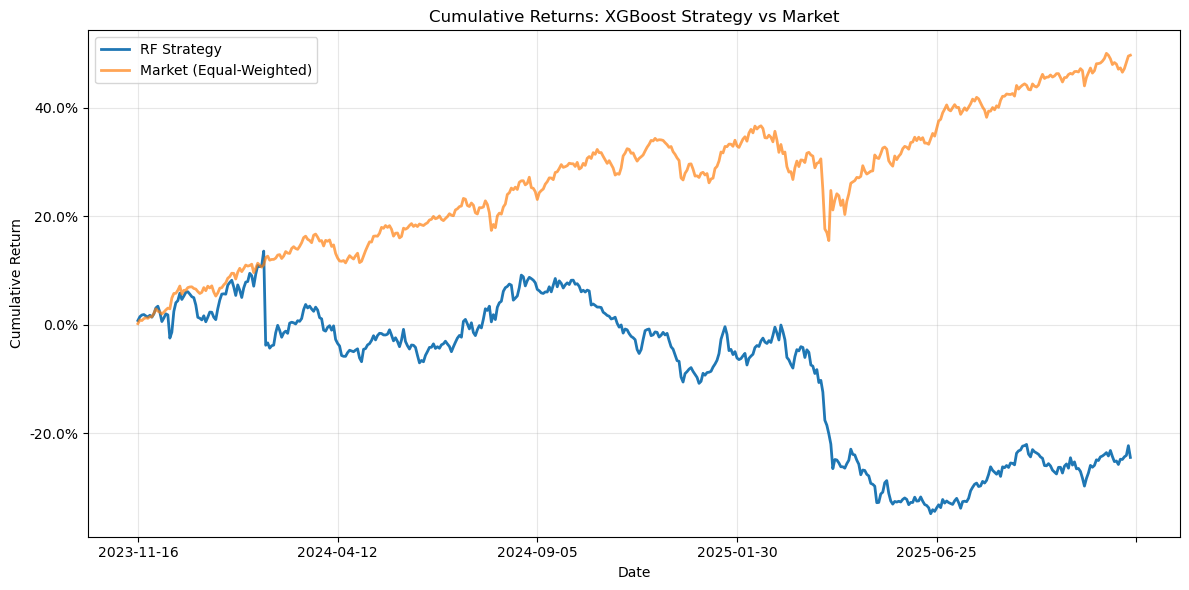

In [53]:
plt.figure(figsize=(12,6))
cumulative_strategy_returns.plot(label='RF Strategy', linewidth=2)
cumulative_market_returns.plot(label='Market (Equal-Weighted)', linewidth=2, alpha=0.7)
plt.title('Cumulative Returns: XGBoost Strategy vs Market')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [54]:
sharpe_strategy = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252) if strategy_returns.std()!=0 else np.nan
sharpe_market = market_returns.mean() / market_returns.std() * np.sqrt(252) if market_returns.std()!=0 else np.nan

print(f"Strategy Total Return: {cumulative_strategy_returns.iloc[-1]:.2%}")
print(f"Market Total Return: {cumulative_market_returns.iloc[-1]:.2%}")
print(f"Strategy Sharpe Ratio: {sharpe_strategy:.2f}")
print(f"Market Sharpe Ratio: {sharpe_market:.2f}")

Strategy Total Return: -24.45%
Market Total Return: 49.69%
Strategy Sharpe Ratio: -0.53
Market Sharpe Ratio: 1.61
